This notebook is a project for Deep Learning School. Here I am going to train neural network for face recognition task, implement different losses and metrics. I am going to use images from CelebA-500 dataset as a trainset and testset, which are already prepared and aligned.

In [1]:
import os
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

from tqdm.notebook import tqdm
from PIL import Image
from skimage import io, transform
from sklearn.metrics.pairwise import cosine_similarity
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

# Step 1. Preparing the dataset

In [2]:
from google.colab import drive, output
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
!gdown 1SfMYMGlJHcULBS2g6SEiA-UYLmzseZ_k
!unzip -q celebA_train_500.zip

Downloading...
From (original): https://drive.google.com/uc?id=1SfMYMGlJHcULBS2g6SEiA-UYLmzseZ_k
From (redirected): https://drive.google.com/uc?id=1SfMYMGlJHcULBS2g6SEiA-UYLmzseZ_k&confirm=t&uuid=4920c85a-6406-4dea-97ad-7c5e14ff2c0c
To: /content/celebA_train_500.zip
100% 170M/170M [00:01<00:00, 143MB/s]


In [4]:
!ls celebA_train_500

celebA_anno.txt  celebA_imgs  celebA_train_split.txt


Let's look over some images

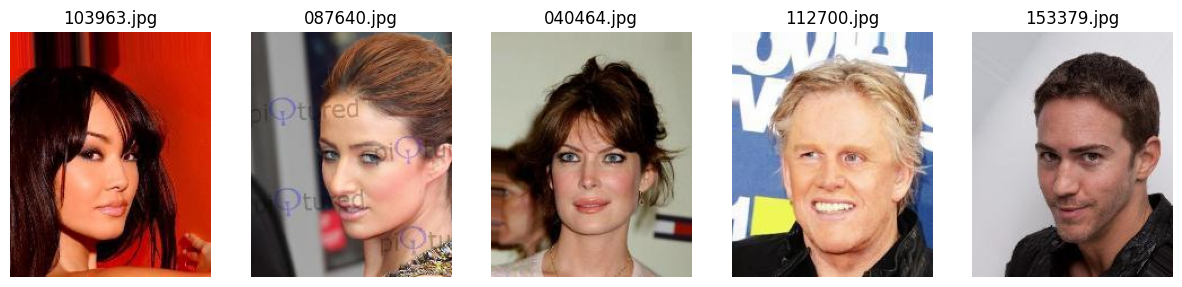

In [5]:
def img_show(img_names):
    img_list = []
    for img_name in img_names:
        im = Image.open(os.path.join('celebA_train_500/celebA_imgs', img_name))
        img_list.append(im)

    fig, axes = plt.subplots(1, len(img_list), figsize=(15, 5))
    for i in range(len(img_list)):
        axes[i].imshow(img_list[i], cmap='gray')
        axes[i].set_title(img_names[i])
        axes[i].axis('off')
    plt.show()

img_names_all = os.listdir('/content/celebA_train_500/celebA_imgs')
img_names = random.choices(img_names_all, k=5)
img_show(img_names)

In [6]:
img_names

['103963.jpg', '087640.jpg', '040464.jpg', '112700.jpg', '153379.jpg']

In [7]:
def get_paths(dataset_type='train'):
    '''
    a function that returnes list of images paths for a given type of the dataset
    params:
      dataset_type: one of 'train', 'val', 'test'
    '''
    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2}

    f = open('/content/celebA_train_500/celebA_train_split.txt', 'r')
    lines = f.readlines()
    f.close()

    lines = [x.strip().split() for x in lines]
    lines = [x[0] for x in lines if int(x[1]) == labels_dict[dataset_type]]

    images_paths = []
    for line in lines:
        path = os.path.join('/content/celebA_train_500/celebA_imgs/', line)
        images_paths.append(path)
    return np.array(images_paths)

In [8]:
class celebADataset(Dataset):
    def __init__(self, dataset_type, tr):
        '''
        building a dataset from files of celebA-500:
          dataset_type: one of 'train', 'val', 'test'
          tr: torchvision.transforms object
          aug: augmentation (optional)
        '''
        self.images = get_paths(dataset_type)
        self.tr = tr

        with open('/content/celebA_train_500/celebA_anno.txt', 'r') as f:
            lines = f.readlines()

        labels = [line.strip().split() for line in lines]
        labels = {elem[0]:elem[1] for elem in labels}
        self.labels = [int(labels[x.split('/')[-1]]) for x in self.images]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_label = self.labels[idx]

        img = Image.open(img_name)
        img_sample = {'image': img, 'label': img_label}

        img_sample['image'] = self.tr(img_sample['image'])
        return img_sample

    def get_person_photos(self, num_person):
        '''
        getting photos of one person:
          num_person: int number of necessary person
        '''
        person_photos = []
        for i, person_number in enumerate(self.labels):
            if person_number == num_person:
                person_photos.append(self.images[i])

        if len(person_photos) != 0:
            photos = torch.stack([self.tr(Image.open(x)) for x in person_photos])
        else:
            photos = torch.Tensor()

        return photos

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(400),
    transforms.Pad((0, 0, 0, 100)),
    transforms.CenterCrop(224),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transform_aug = transforms.Compose([
    transform,
    transforms.RandomHorizontalFlip(p=0.7)
])

train_dataset_real = celebADataset(dataset_type='train', tr=transform)
train_dataset_augmented = celebADataset(dataset_type='train', tr=transform_aug)
train_dataset = torch.utils.data.ConcatDataset([train_dataset_real, train_dataset_augmented])
val_dataset = celebADataset(dataset_type='val', tr=transform)
test_dataset = celebADataset(dataset_type='test', tr=transform)

BATCH_SIZE = 32
train_loader_real = torch.utils.data.DataLoader(train_dataset_real, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

def show_loader_images(loader, n):
    '''
    Shows some images from dataloader:
      loader: torch.utils.data.DataLoader
      n: amount of images to show
    '''
    batch = next(iter(train_loader))
    images_batch = batch['image']
    labels_batch = batch['label']
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i, ax in enumerate(axes):
        img = images_batch[i].permute(1, 2, 0)
        ax.imshow(torch.sigmoid(img))
        ax.set_title(labels_batch[i].item())
    plt.show()

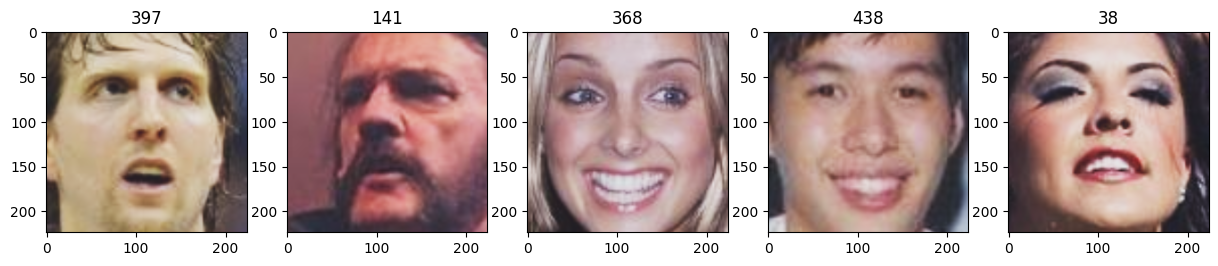

In [10]:
show_loader_images(train_loader, 5)

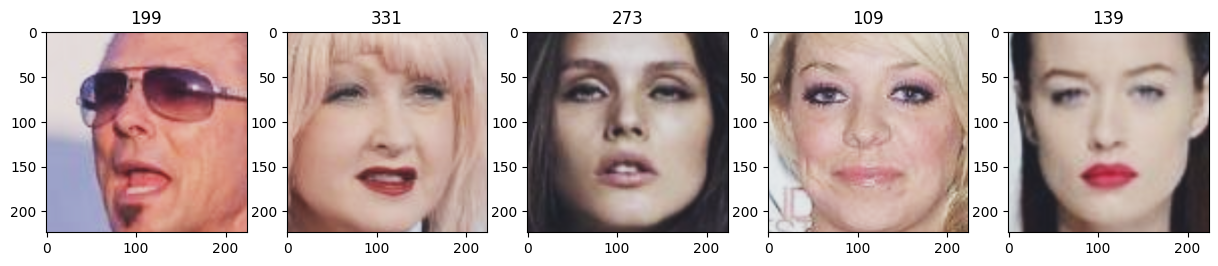

In [11]:
show_loader_images(train_loader_real, 5)

Counting how many images are in datasets and how many batches are in dataloaders

In [12]:

objects_lengths = {
    'train_dataset_real': len(train_dataset_real),
    'train_dataset': len(train_dataset),
    'val_dataset': len(val_dataset),
    'test_dataset': len(test_dataset),
    'train_loader': len(train_loader),
    'val_loader': len(val_loader),
    'test_loader': len(test_loader)
}

for elem in objects_lengths.items():
    print('len of {} is {}'.format(elem[0], elem[1]))

len of train_dataset_real is 8544
len of train_dataset is 17088
len of val_dataset is 1878
len of test_dataset is 1589
len of train_loader is 534
len of val_loader is 59
len of test_loader is 50


# Step 2. Training a classification model

Next we train our model on train_dataset using standard cross-enthropy loss. Let's implement training algorithm here:

In [13]:
def train_epoch(model, dataloader, loss_fn, optimizer):
    losses = []
    num_correct = 0
    num_elements = 0
    model.train()
    for i, batch in enumerate(dataloader):
        X_batch, y_batch = batch['image'], batch['label']
        num_elements += len(y_batch)
        optimizer.zero_grad()
        logits = model(X_batch.to(device))
        loss = loss_fn(logits, y_batch.to(device))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        y_pred = torch.argmax(logits, dim=1)
        num_correct += torch.sum(y_pred.cpu() == y_batch)
    train_accuracy = num_correct / num_elements
    train_losses = np.mean(losses)
    return train_losses, train_accuracy.numpy()

def eval_epoch(model, dataloader, loss_fn):
    losses = []
    num_correct = 0
    num_elements = 0
    model.eval()
    for i, batch in enumerate(dataloader):
        X_batch, y_batch = batch['image'], batch['label']
        num_elements += len(y_batch)
        with torch.no_grad():
            logits = model(X_batch.to(device))
            loss = loss_fn(logits, y_batch.to(device))
            losses.append(loss.item())
            y_pred = torch.argmax(logits, dim=1)
            num_correct += torch.sum(y_pred.cpu() == y_batch)
    val_accuracy = num_correct / num_elements
    val_losses = np.mean(losses)
    return val_losses, val_accuracy.numpy()

def train(train_loader, val_loader, model, epochs, optimizer,):
    history = []
    best_val_acc = 0
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        loss_fn = nn.CrossEntropyLoss()
        for epoch in range(epochs):
            train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer)
            print("loss", train_loss)
            val_loss, val_acc = eval_epoch(model, val_loader, loss_fn)
            if val_acc >= best_val_acc:
                checkpoint = {
                    'model': model,
                    'losses': (train_loss, train_acc, val_loss, val_acc),
                    'epoch': epoch}
                torch.save(checkpoint, '/content/gdrive/MyDrive/model/best_model.pt')
            history.append((train_loss, train_acc, val_loss, val_acc))
            torch.save(history, '/content/gdrive/MyDrive/model/history.pt')
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

I have used pretrained efficientnet_b1 to classify pictures

In [14]:
model = efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V2)
model.classifier

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 106MB/s] 


Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In this task the dataset contains 500 different classes, so let's change the last FC layer and also add batchnorm layer

In [15]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=1000, bias=True),
    nn.BatchNorm1d(1000),
    nn.Linear(in_features=1000, out_features=500, bias=True)
)

In [16]:
opt = torch.optim.Adam(model.parameters())
loss = nn.CrossEntropyLoss()

In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
device

device(type='cuda')

In [25]:
train(train_loader, val_loader, model, epochs=10, optimizer=opt)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.9631781372684665

Epoch 001 train_loss: 2.9632     val_loss 1.6911 train_acc 0.4069 val_acc 0.5996
loss 0.5541591502251696

Epoch 002 train_loss: 0.5542     val_loss 1.3049 train_acc 0.8631 val_acc 0.7109
loss 0.22960691935337438

Epoch 003 train_loss: 0.2296     val_loss 1.3344 train_acc 0.9381 val_acc 0.7130
loss 0.2617596908078323

Epoch 004 train_loss: 0.2618     val_loss 1.4141 train_acc 0.9227 val_acc 0.7167
loss 0.23537395205976588

Epoch 005 train_loss: 0.2354     val_loss 1.5530 train_acc 0.9324 val_acc 0.7141
loss 0.19788961740357153

Epoch 006 train_loss: 0.1979     val_loss 1.5723 train_acc 0.9410 val_acc 0.7274
loss 0.19091620084730218

Epoch 007 train_loss: 0.1909     val_loss 1.4954 train_acc 0.9450 val_acc 0.7380
loss 0.19459056645659695

Epoch 008 train_loss: 0.1946     val_loss 1.5724 train_acc 0.9437 val_acc 0.7258
loss 0.1408256820356386

Epoch 009 train_loss: 0.1408     val_loss 1.5398 train_acc 0.9568 val_acc 0.7476
loss 0.11737398297350665

Epoch 010 train

In total the model was trained through 10 epochs. At first, let's visualize the process of training by drawing plots of losses and accuracies. Then, we can evaluate its quality on test data.

In [18]:
history = torch.load('/content/gdrive/MyDrive/model/history.pt')
train_loss, train_acc, val_loss, val_acc = zip(*history)

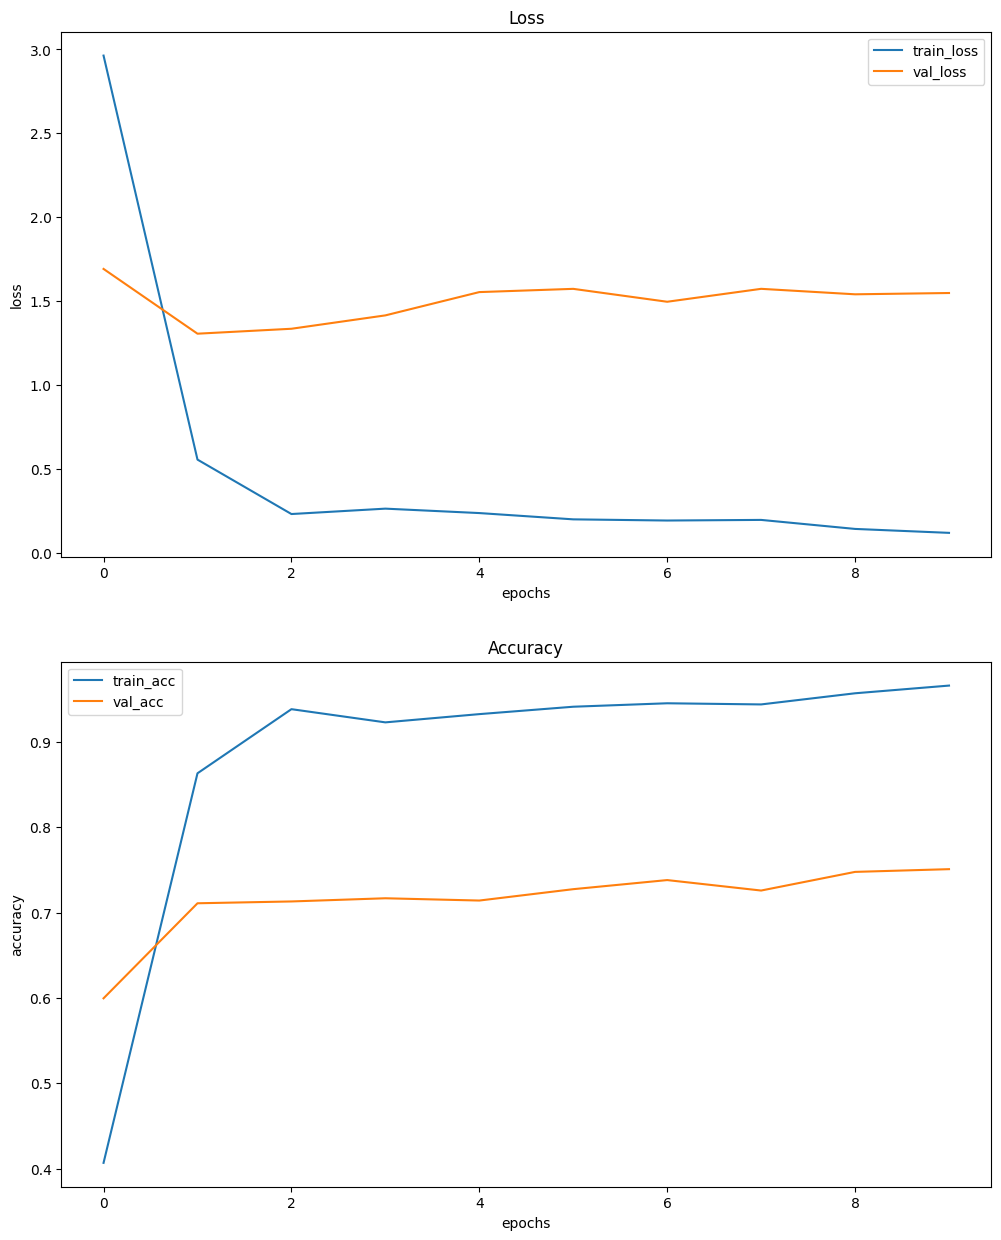

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(12, 15))
axes[0].plot(train_loss, label='train_loss')
axes[0].plot(val_loss, label='val_loss')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('loss')
axes[0].set_title('Loss')
axes[0].legend()

axes[1].plot(train_acc, label='train_acc')
axes[1].plot(val_acc, label='val_acc')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('accuracy')
axes[1].set_title('Accuracy')
axes[1].legend()
plt.show()

In [20]:
def evaluate(model, dataloader, loss_fn):
    losses = []
    num_correct = 0
    num_elements = 0
    model.eval()
    for i, batch in enumerate(dataloader):
        output.clear()
        print(f'Batch #{i+1} from {len(dataloader)}')
        X_batch, y_batch = batch['image'], batch['label']
        num_elements += len(y_batch)
        with torch.no_grad():
            logits = model(X_batch.to(device))
            loss = loss_fn(logits, y_batch.to(device))
            losses.append(loss.item())
            y_pred = torch.argmax(logits, dim=1)
            num_correct += torch.sum(y_pred.cpu() == y_batch)
    accuracy = num_correct / num_elements
    return accuracy.numpy(), np.mean(losses)

In [21]:
load_checkpoint = torch.load('/content/gdrive/MyDrive/model/best_model.pt', map_location=device)
best_model = load_checkpoint['model']

In [22]:
test_accuracy, test_loss = evaluate(best_model, test_loader, loss)

Batch #50 from 50


In [23]:
test_accuracy

array(0.73379487, dtype=float32)

# Step 3. Computing cosine similarity

If we drop the last classification layer, we will get embeddings of pictures as an output of the model. This embeddings must be quite similar for different pictures of one person and must be more different for different pictures of different persons. To measure this similarity we use the metric named cosine similarity. Let's check this suggestion in our case.

In [24]:
del best_model.classifier[-1]
best_model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
  (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

So now the last layer of the model is batchnorm layer

In [25]:
best_model.eval()
# checking persons № 5 and № 150
with torch.no_grad():
    person_2 = best_model(train_dataset_real.get_person_photos(5).to(device))
    person_2_test = best_model(test_dataset.get_person_photos(5).to(device))
    person_150_test = best_model(test_dataset.get_person_photos(150).to(device))

print(cosine_similarity(person_2_test.cpu(), person_2.cpu()).mean())
print(cosine_similarity(person_2.cpu(), person_150_test.cpu()).mean())

0.48344743
0.012054395


We see that cosine similarity is smaller, when it's calculated between different people.

# Step 4. Implementing IR metric

The first thing to do is downloading dataset "celebA_ir", which we are going to use to calculate metric

In [28]:
! unzip -qq celebA_ir.zip

In [29]:
from collections import defaultdict

f = open('./celebA_ir/celebA_anno_query.csv', 'r')
query_lines = f.readlines()[1:]
f.close()
query_lines = [x.strip().split(',') for x in query_lines]
query_img_names = ['./celebA_ir/celebA_query/{}'.format(x[0]) for x in query_lines]

query_dict = defaultdict(list)
for img_name, img_class in query_lines:
    query_dict[img_class].append(img_name)

distractors_img_names = ['./celebA_ir/celebA_distractors/{}'.format(x) for x in os.listdir('./celebA_ir/celebA_distractors')]

In [30]:
print(len(distractors_img_names))
print(len(query_img_names))
print(len(query_dict))

2001
1222
51


In [31]:
class celebA_ir_Dataset(Dataset):
    def __init__(self, images_list,
                 transform=transforms.Compose([
                                              transforms.ToTensor(),
                                              transforms.Resize(400),
                                              transforms.Pad((0, 0, 0, 100)),
                                              transforms.CenterCrop(224),
                                              transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                               ])):
        self.images = images_list
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def get_tensors(self):
        images = torch.stack([self.transform(Image.open(img_name)) for img_name in self.images])
        return images

    def __getitem__(self, idx):
        img_name = self.images[idx]
        image = Image.open(img_name)

        return self.transform(image), idx

In [32]:
def compute_embeddings(model, images_list):
  '''
  compute embeddings from the trained model for list of images.
  params:
    model: trained nn model that takes images and outputs embeddings
    images_list: list of images paths to compute embeddings for
  output:
    list: list of model embeddings. Each embedding corresponds to images
          names from images_list
  '''
  dataset = celebA_ir_Dataset(images_list)
  model.to(device)
  loader = torch.utils.data.DataLoader(dataset.get_tensors(), batch_size=32, shuffle=False, num_workers=2)

  model.eval()
  embeddings = []
  with torch.no_grad():
      for xbatch in loader:
          outputs = model(xbatch.to(device))
          embeddings.append(outputs.cpu())
  return torch.cat(embeddings)

In [33]:
query_embeddings = compute_embeddings(best_model, query_img_names)
distractors_embeddings = compute_embeddings(best_model, distractors_img_names)

In [35]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
  '''
  compute cosine similarities between positive pairs from query (stage 1)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding
                    to the same people from query list
  '''
  for person_class in query_dict:
      if query_dict[person_class][0] not in query_img_names:
          PATH = './celebA_ir/celebA_query/{}'
      else:
          PATH = '{}'
      break

  full_embeddings = torch.Tensor()

  for person_class in query_dict:
      images = [PATH.format(x) for x in query_dict[person_class]]
      person_embeddings = []
      for image_path in images:
          person_embeddings.append(
              torch.Tensor(query_embeddings[query_img_names.index(image_path)])
              )
      if len(person_embeddings) == 0:
          person_embeddings = torch.Tensor
          result = 0.0
      else:
          person_embeddings = torch.stack(person_embeddings)
          result = cosine_similarity(np.array(person_embeddings), np.array(person_embeddings))
          df = pd.DataFrame(result)

          df = df.mask(np.tril(np.ones(df.shape, dtype=np.bool_))).values.reshape(-1)
          useful_result = df[~np.isnan(df)] # drop nan

          useful_result = torch.Tensor(useful_result).view(-1)
          full_embeddings = torch.cat((full_embeddings, useful_result))
  results = [i.item() for i in full_embeddings]
  print('Count of cosine similarities =', len(results))
  return results

def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
  '''
  compute cosine similarities between negative pairs from query (stage 2)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding
                    to different people from query list
  '''
  for person_class in query_dict:
      if query_dict[person_class][0] not in query_img_names:
          PATH = './celebA_ir/celebA_query/{}'
      else:
          PATH = '{}'
      break

  full_embeddings = torch.Tensor()
  class_counter = []

  k = 0
  for person_class in query_dict:
      k += 1
      images = [PATH.format(x) for x in query_dict[person_class]]
      class_counter.extend([person_class for i in range(len(images))])

      person_embeddings = []
      for image_path in images:
          person_embeddings.append(
                torch.Tensor(query_embeddings[query_img_names.index(image_path)])
          )
      if len(person_embeddings) == 0:
          person_embeddings = torch.Tensor
          result = 0.0
      else:
          person_embeddings = torch.stack(person_embeddings)
          full_embeddings = torch.cat((full_embeddings, person_embeddings))

  all_data = pd.DataFrame(data={'class': class_counter, 'embeddings': list(full_embeddings)})
  results = cosine_similarity(full_embeddings, full_embeddings)
  results = pd.DataFrame(data=results, index=class_counter, columns=class_counter)

  for i in results:
      results.loc[i, i] = np.nan

  df = results.mask(np.tril(np.ones(results.shape, dtype=np.bool_))).values.reshape(-1)
  useful_result = df[~np.isnan(df)] # drop nan
  print('Count of cosine similarities =', len(useful_result))
  return useful_result

def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
  '''
  compute cosine similarities between negative pairs from query and distractors
  (stage 3)
  params:
    query_embeddings: list of embeddings corresponding to query_img_names
    distractors_embeddings: list of embeddings corresponding to distractors_img_names
  output:
    list of floats: similarities between pairs of people (q, d), where q is
                    embedding corresponding to photo from query, d —
                    embedding corresponding to photo from distractors
  '''
  results = cosine_similarity(query_embeddings, distractors_embeddings)
  results = results.reshape(-1)
  print('Count of cosine similarities =', len(results))
  return results

In [36]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings,
                                                            distractors_embeddings)

Count of cosine similarities = 14721
Count of cosine similarities = 731310
Count of cosine similarities = 2445222


Next cells contain test of the code

In [37]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = [
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
]

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings,
                                                            test_distractors_embeddings)

Count of cosine similarities = 4
Count of cosine similarities = 11
Count of cosine similarities = 30


In [38]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

The final task of this step is to implement IR metric function

In [39]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors,
               fpr=0.1):
  '''
  compute identification rate using precomputer cosine similarities between pairs
  at given fpr
  params:
    cosine_query_pos: cosine similarities between positive pairs from query
    cosine_query_neg: cosine similarities between negative pairs from query
    cosine_query_distractors: cosine similarities between negative pairs
                              from query and distractors
    fpr: false positive rate at which to compute TPR
  output:
    float: threshold for given fpr
    float: TPR at given FPR
  '''
  cosine_query_pos = torch.Tensor(cosine_query_pos)
  cosine_query_neg = torch.Tensor(cosine_query_neg)
  cosine_query_distractors = torch.Tensor(cosine_query_distractors)

  false_pairs = torch.cat((cosine_query_neg, cosine_query_distractors))
  N = round(fpr * len(false_pairs))
  false_pairs = torch.sort(false_pairs, descending = True)[0]
  threshold = false_pairs[N]
  TPR = len(cosine_query_pos[cosine_query_pos > threshold]) / len(cosine_query_pos)
  return threshold.item(), TPR

Checking the last function

In [40]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
  x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg,
                    test_cosine_query_distractors, fpr=fpr)
  test_thr.append(x)
  test_tpr.append(y)

true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

Below we count TPR@FPR for faces in `celebA_ir` dataset. We take FPR = [0.5, 0.2, 0.1, 0.05]

In [41]:
all_thr = []
all_tpr = []

for fpr in [0.5, 0.2, 0.1, 0.05]:
    print('Analyse by fpr = {}'.format(fpr))
    x, y = compute_ir(cosine_query_pos, cosine_query_neg,
                      cosine_query_distractors, fpr=fpr)
    all_thr.append(x)
    all_tpr.append(y)
    output.clear()

print(all_thr)
print(all_tpr)

[0.5488647222518921, 0.6443071365356445, 0.6878998875617981, 0.7205345034599304]
[0.7289586305278174, 0.4323755179675294, 0.2956320902112628, 0.20086950614768018]


And make a plot showing that relationship between tpr and fpr is almost linear.

Text(0.5, 1.0, 'TPR@FPR')

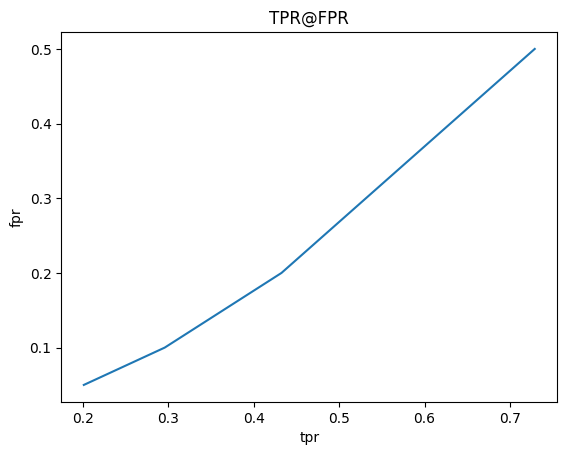

In [42]:
plt.plot(all_tpr, [0.5, 0.2, 0.1, 0.05])
plt.xlabel('tpr')
plt.ylabel('fpr')
plt.title('TPR@FPR')

# Step 5. Training the model using ArcFace loss

In [43]:
class ArcFace(nn.Module):
    def __init__(self, in_features, out_features, s=64.0, m=0.5, easy_margin=False, ls_eps=0.0):
        super(ArcFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = torch.zeros(cosine.size(), device=device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

We take our model and add a new arcface layer to it.

In [44]:
arcface_model = efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V2)

In [45]:
class ArcFace_model(nn.Module):
    def __init__(self):
        super(ArcFace_model, self).__init__()

        self.encoding = arcface_model
        self.bn1 = nn.BatchNorm1d(1000)
        self.arcface = ArcFace(1000, 500)

    def forward(self, x, labels=None):
        x = self.encoding(x)
        x = self.bn1(x)
        if labels is not None:
            x = self.arcface(x, labels)
        return x

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
arcface_model = ArcFace_model().to(device)

opt = torch.optim.Adam(arcface_model.parameters())
loss = nn.CrossEntropyLoss()

In [49]:
train(train_loader, val_loader, arcface_model, epochs=10, optimizer=opt)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 5.331993412882201

Epoch 001 train_loss: 5.3320     val_loss 3.6184 train_acc 0.1620 val_acc 0.4297
loss 3.1862591464867753

Epoch 002 train_loss: 3.1863     val_loss 2.0652 train_acc 0.5904 val_acc 0.6459
loss 2.112210356117634

Epoch 003 train_loss: 2.1122     val_loss 1.5096 train_acc 0.8196 val_acc 0.7125
loss 1.4737424658478868

Epoch 004 train_loss: 1.4737     val_loss 1.2550 train_acc 0.9137 val_acc 0.7540
loss 1.0645286640647644

Epoch 005 train_loss: 1.0645     val_loss 1.1637 train_acc 0.9542 val_acc 0.7758
loss 0.7927778407875519

Epoch 006 train_loss: 0.7928     val_loss 1.1067 train_acc 0.9731 val_acc 0.7934
loss 0.6210930961348144

Epoch 007 train_loss: 0.6211     val_loss 1.1584 train_acc 0.9769 val_acc 0.7833
loss 0.4834804255306051

Epoch 008 train_loss: 0.4835     val_loss 1.1254 train_acc 0.9826 val_acc 0.7945
loss 0.41903869327757687

Epoch 009 train_loss: 0.4190     val_loss 1.1930 train_acc 0.9796 val_acc 0.7822
loss 0.3590615675243992

Epoch 010 train_loss: 

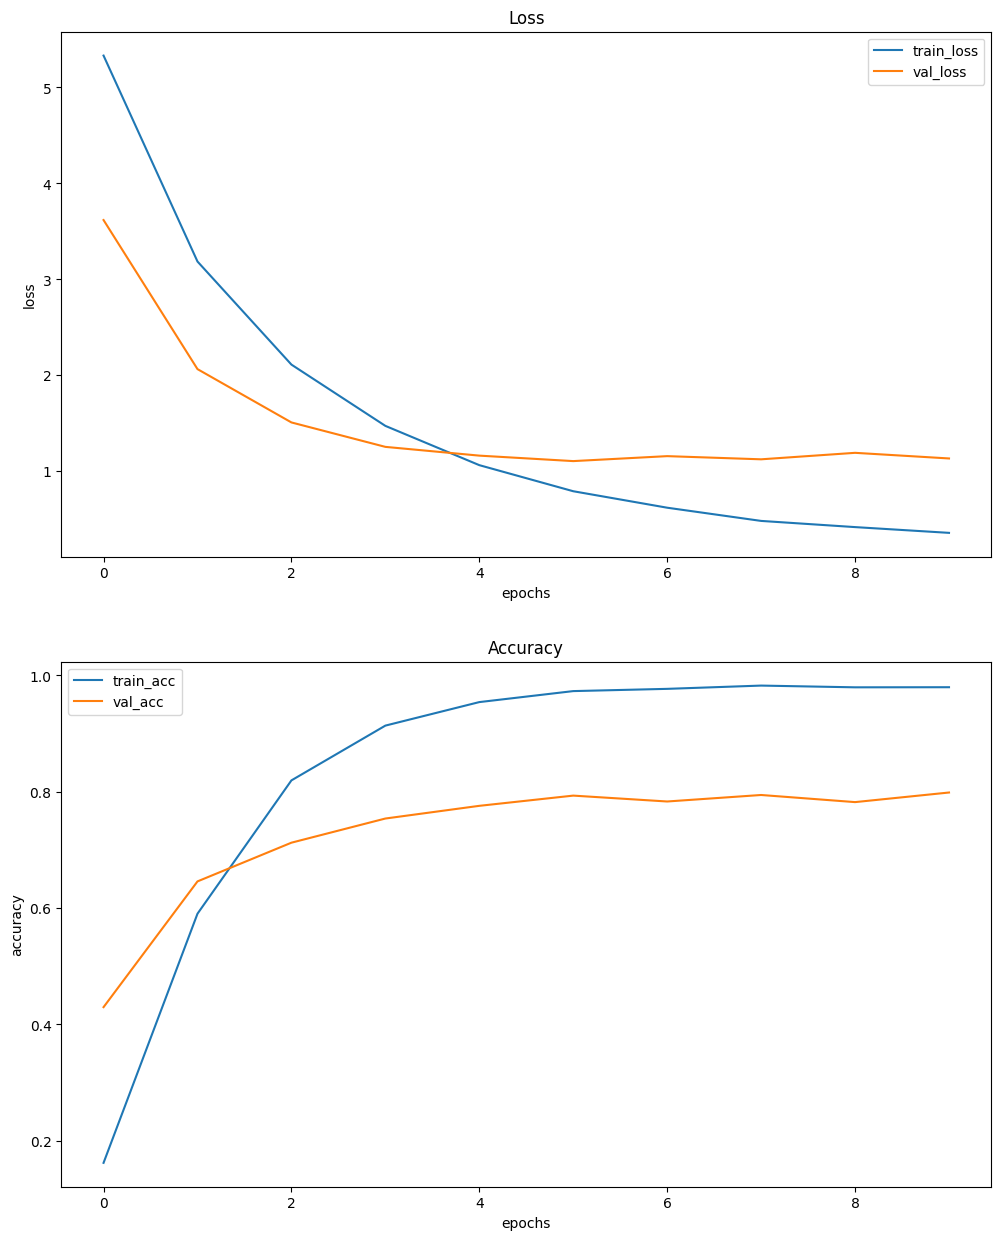

In [50]:
history = torch.load('/content/gdrive/MyDrive/model/history.pt')
train_loss, train_acc, val_loss, val_acc = zip(*history)

fig, axes = plt.subplots(2, 1, figsize=(12, 15))
axes[0].plot(train_loss, label='train_loss')
axes[0].plot(val_loss, label='val_loss')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('loss')
axes[0].set_title('Loss')
axes[0].legend()

axes[1].plot(train_acc, label='train_acc')
axes[1].plot(val_acc, label='val_acc')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('accuracy')
axes[1].set_title('Accuracy')
axes[1].legend()
plt.show()

In [51]:
load_checkpoint = torch.load('/content/gdrive/MyDrive/model/best_model.pt', map_location=device)
best_model = load_checkpoint['model']

test_accuracy, test_loss = evaluate(best_model, test_loader, loss)
test_accuracy

Batch #50 from 50


array(0.7847703, dtype=float32)

Done! Quality of the model increased!

**Resume:**
*   In this project I used pretrained model EfficientNet_b2 for the task of face recognition
*   It was confirmed that this model gives correct embeddings as an output. Faces of one person have similar embeddings, and faces of different persons have different embeddings.
*   Implemented TPR@FPR metric, counted it on the dataset
*   Implemented ArcFace loss, trained model using it

**Final quality:**
*   Using cross-entropy: 0.734
*   Using Arcface loss: 0.785


In [53]:
del best_model
del model

import gc
gc.collect()
torch.cuda.empty_cache()